<a href="https://colab.research.google.com/github/fortmaad/fortmaad.github.io/blob/main/Music_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Song Popularity

## Introduction

This project attempt to predict whether or not a song will reach the BillBoard Hot 100 based on identifiable characteristics of a song, such as the genre, tempo, key, among others. This project leverages the Spotify API to collect song data via the ```spotipy``` module, the ```billboard``` python module which scrapes the Billboard website for hot 100 songs, and the ```PyCaret``` module for automated (low-coding) machine learning.

## Overview

To create two classes for prediction, a song can either be "hot" or "not hot", which is determined by if a song appears in the Billboard Hot 100 songs. The assumption that a song is not hot if it does not appear in the Billboard is a naive one, but we will proceed for the sake of simplicity.

### Steps:

- Download and import packages
- Scrape Billboard for hot song names
- Use Spotify API
    - Search for hot song names and get data
    - Select not hot songs and get data
- Create predictive model to classify songs

## Download Packages

PyCaret requires specific versions of python and other packages. I recommend this to be run on some cloud platform to avoid issues with PyCaret. All code was created and run in Google Colab.

In [1]:
!pip install billboard.py spotipy fuzzywuzzy pycaret Jinja2==3.1.2 shap
!pip install --upgrade urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 21.8 MB/s 
     |████████████████████████████████| 133 kB 38.0 MB/s 
     |████████████████████████████████| 564 kB 6.9 MB/s 
     |████████████████████████████████| 62 kB 897 kB/s 
     |████████████████████████████████| 120 kB 36.5 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 17.8 MB 9.3 MB/s 
     |████████████████████████████████| 6.8 MB 37.1 MB/s 
     |████████████████████████████████| 167 kB 41.0 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 
     |████████████████████████████████| 262 kB 35.5 MB/s 
     |████████████████████████████████| 2.0 MB 42.7 MB/s 
     |████████████████████████████████| 1.7 MB 49.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel met

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 26.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd # dataframe operations
import numpy as np # data manipulation operations

## Billboard Hot 100 Data

The billboard module is easy to use, requiring only the type of chart desired and the date. We will create a loop which pulls 2 charts for every year of interest (January 1 and June 1). All we care about keeping is the artist name and the song name.

In [3]:
import billboard

years = range(2013,2021) # select the years we want from the billboards
song, artist, weeks = [],[],[]

# loop for billboard data
for i in years:
  if i % 2 == 0: date = str(i) + "-01-01" # alternate beteen Jan and Jun
  else: date = str(i) + "-06-01" 
  chart = billboard.ChartData('hot-100', date = date) # extract chart data
  row = 0
  while row < 100: # getting artist and song name for every row in the billboard
    song.append(chart[row].title) # append song name
    artist.append(chart[row].artist) # append artist name
    row += 1 # go to next row

The cell below replaces the various ways Billboard represents artist featured on songs with a comma and a space for consistency. To search for artists in the Spotify API, the primary artist of a song must be separated from the
secondary (featured artist). Billboard’s method of showing artists is including the features in the
artist name. To isolate the primary artist, we used Billboard’s delimiters and split all artists,
keeping the first artist.


In [4]:
artist = [a.replace(" & ", ", ") for a in artist]
artist = [a.replace(" X ", ", ") for a in artist]
artist = [a.replace(" Featuring ", ", ") for a in artist]
artist = [a.replace(" + ", ", ") for a in artist]

The cell below removes artists which are features on a billboard song. For example:
  "Jay-Z, Alicia Keys" becomes "Jay-Z".

In [5]:
billboard_df = pd.DataFrame({'song':song, 'artist':artist})
billboard_df['artist'] = billboard_df['artist'].str.replace(',.*', '')
billboard_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,song,artist
0,Can't Hold Us,Macklemore
1,Just Give Me A Reason,P!nk
2,Mirrors,Justin Timberlake


Since we used data from January for each year, there are bound to be repeat songs on the
Billboard because of seasonal songs like Mariah Carey’s “All I want for Christmas” which
appears on the Billboard every year. Around 9% of the songs in the Billboards were duplicates,
so we removed any appearance after the first to keep only unique songs from artists.

In [6]:
duplicates = billboard_df[billboard_df.duplicated(['song','artist'], keep=False)] # duplicates
dup_prop = duplicates.shape[0]/billboard_df.shape[0] # proportion of duplicates
print(dup_prop * 100, '% of entries are duplicate songs')

9.375 % of entries are duplicate songs


In [7]:
billboard_df = billboard_df.drop_duplicates() # remove duplicate songs
billboard_df.head()

,song,artist
0,Can't Hold Us,Macklemore
1,Just Give Me A Reason,P!nk
2,Mirrors,Justin Timberlake
3,When I Was Your Man,Bruno Mars
4,Stay,Rihanna


## Spotify Song Data

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [9]:
# spotify credentials
cid = "22610364d71a49f7a77b6cf02732357f"
secret = "11d5e86ac1004b29b7bdcb100390935e"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

### Hot Song Data

We will match the names used in the Billboards and in Spotify for each
artist and song. Since the names are not exactly the same (for example, “Kesha” and “Ke$ha”),
we will use fuzzy logic for string approximation. We will arbitrarily choose a fuzz ratio of .7, which is essentially a similarity ratio, to match each artist in the Billboard to Spotify.

Then, we will save some of the hot song data.

In [10]:
from fuzzywuzzy import fuzz # for string (artist name) approximation

artist_ids = []
uris = []
sp_artist = []
hot_song_name = []
release_date = []
explicit = []
tick = 0


for item in billboard_df['song']: # for each song in the billboard
  query = sp.search(q = item, type = "track", limit = 1) # search for the song name
  if fuzz.ratio(query['tracks']['items'][0]['album']['artists'][0]['name'].lower(),artist[tick].lower()) >= .7: # check to see if the artist's name for that song matches the billboard's
    uris.append(query['tracks']['items'][0]['uri']) # get song uri
    hot_song_name.append(query['tracks']['items'][0]['name']) # get spotify's name for the song
    artist_ids.append(query['tracks']['items'][0]['album']['artists'][0]['id']) # get artist's id
    sp_artist.append(query['tracks']['items'][0]['album']['artists'][0]['name']) # save Spotify's name for the artist
    release_date.append(query['tracks']['items'][0]['album']['release_date']) # save album/song release date
    explicit.append(query['tracks']['items'][0]['explicit']) # explicit variable
  tick += 1 # increment loop

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


To retreive acoustic song data, we must run a separate query.

In [11]:
# Make lists from previous cell into dataframe
hot_df = pd.DataFrame({'uri':uris, 'artist':sp_artist, 'song':hot_song_name, 'release_date':release_date, 'explicit':explicit})
hot_df.head(3)

,uri,artist,song,release_date,explicit
0,spotify:track:3bidbhpOYeV4knp8AIu8Xn,Macklemore & Ryan Lewis,Can't Hold Us (feat. Ray Dalton),2012-10-09,False
1,spotify:track:1mKXFLRA179hdOWQBwUk9e,P!nk,Just Give Me a Reason (feat. Nate Ruess),2012-09-18,False
2,spotify:track:4rHZZAmHpZrA3iH5zx8frV,Justin Timberlake,Mirrors,2013-03-15,False


Since Spotify limits audio feature searches to 100 songs, we divide the hot dataframe into chunks with size 100 and query each chunk.

In [12]:
chunks = [uris[x:x+100] for x in range(0, len(uris), 100)] 

In [13]:
hot_ac = pd.DataFrame()
chunk_not_working = 0
for group in chunks:
  try:
    temp = pd.DataFrame(sp.audio_features(tracks = group)) # search for audio features of songs in chunk
    hot_ac = pd.concat([hot_ac, temp]) # append audio features to dataframe
  except: 
    chunk_not_working += 1
    print("Chunks not working: ",chunk_not_working) # for some odd reason, sometimes a chunk will not work

In [14]:
hot_ac.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.641,0.922,2,-4.457,1,0.0786,0.0291,0.000000,0.0862,0.847,146.078,audio_features,3bidbhpOYeV4knp8AIu8Xn,spotify:track:3bidbhpOYeV4knp8AIu8Xn,https://api.spotify.com/v1/tracks/3bidbhpOYeV4...,https://api.spotify.com/v1/audio-analysis/3bid...,258343,4
1,0.778,0.547,2,-7.273,1,0.0489,0.3460,0.000302,0.1320,0.441,95.002,audio_features,1mKXFLRA179hdOWQBwUk9e,spotify:track:1mKXFLRA179hdOWQBwUk9e,https://api.spotify.com/v1/tracks/1mKXFLRA179h...,https://api.spotify.com/v1/audio-analysis/1mKX...,242733,4
2,0.574,0.512,5,-6.664,0,0.0503,0.2340,0.000000,0.0946,0.512,76.899,audio_features,4rHZZAmHpZrA3iH5zx8frV,spotify:track:4rHZZAmHpZrA3iH5zx8frV,https://api.spotify.com/v1/tracks/4rHZZAmHpZrA...,https://api.spotify.com/v1/audio-analysis/4rHZ...,484147,4


In [15]:
hot_ac = hot_ac.drop(columns=['type', 'id', 'track_href', 'analysis_url','uri']) # get rid of useless columns
hot_ac = hot_ac.loc[:,~hot_ac.columns.duplicated()] # remove one of the uri columns since it appears twice

Whether or not a song has another artist featured likely provides some useful information, so
before splitting and removing the featured names from the Spotify song name, we will create an
indicator variable for if there is a second artist on the song.

In [16]:
hot_df = pd.concat([hot_df.reset_index(drop=True), hot_ac.reset_index(drop=True)], axis = 1) # merge general song data with acoustic data
hot_df['feature'] = 0
hot_df.loc[hot_df['song'].str.contains('\(feat.*'),'feature'] = 1
hot_df.loc[hot_df['song'].str.contains('\(with.*'),'feature'] = 1
hot_df['song'] = hot_df['song'].str.replace('\(feat.*', '') # get rid of other artists for simplicity sake
hot_df['song'] = hot_df['song'].str.replace('\(with.*', '') # 
hot_df['hot'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [17]:
hot_df.head(3)

,uri,artist,song,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,feature,hot
0,spotify:track:3bidbhpOYeV4knp8AIu8Xn,Macklemore & Ryan Lewis,Can't Hold Us,2012-10-09,False,0.641,0.922,2,-4.457,1,0.0786,0.0291,0.000000,0.0862,0.847,146.078,258343,4,1,1
1,spotify:track:1mKXFLRA179hdOWQBwUk9e,P!nk,Just Give Me a Reason,2012-09-18,False,0.778,0.547,2,-7.273,1,0.0489,0.3460,0.000302,0.1320,0.441,95.002,242733,4,1,1
2,spotify:track:4rHZZAmHpZrA3iH5zx8frV,Justin Timberlake,Mirrors,2013-03-15,False,0.574,0.512,5,-6.664,0,0.0503,0.2340,0.000000,0.0946,0.512,76.899,484147,4,0,1


The code below creates genre variables associated with a specific artist. Unfortunately, Spotify does not attach a genre to individual songs or albums, a severe limitation of the API.

In [18]:
genre = []
for artist in hot_df['artist']:
   genre.append(sp.search(q=artist, type = "artist", limit = 1)['artists']['items'][0]['genres'])

hot_df['genre'] = genre

Because an artist can have multiple genres, we create dummy variables for various genres. For
simplicity, we will group all songs into seven genres: pop, rap, rock, country, electro (edm), R&B,
and other. If an artist’s list of associated genres included any words associated with a genre (such
as “metal” or “alternative” for the rock genre), the column for that genre is marked with a
“1”. The genre variables are oversimplified for the project’s sake.

In [19]:
hot_df["pop"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['pop','dance']) else 0)
hot_df["rap"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['hip','hop','rap']) else 0)
hot_df["rock"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['alternative','metal','rock','roll']) else 0)
hot_df["country"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['country']) else 0)
hot_df["electro"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['edm','electro']) else 0)
hot_df["r&b"] = hot_df['genre'].apply(lambda x: 1 if any(i in x for i in ['jazz','r&b','soul','funk']) else 0)
hot_df['other'] = np.where(((hot_df['pop'] == 0) & (hot_df['rap'] == 0) & (hot_df['rock'] == 0) & (hot_df['country'] == 0) & (hot_df['electro'] == 0) & (hot_df['rap'] == 0) & (hot_df['r&b'] == 0)), 1, 0)
hot_df = hot_df.drop(columns='genre')

In [20]:
hot_df.head(3)

,uri,artist,song,release_date,explicit,danceability,energy,key,loudness,mode,...,time_signature,feature,hot,pop,rap,rock,country,electro,r&b,other
0,spotify:track:3bidbhpOYeV4knp8AIu8Xn,Macklemore & Ryan Lewis,Can't Hold Us,2012-10-09,False,0.641,0.922,2,-4.457,1,...,4,1,1,1,0,0,0,0,0,0
1,spotify:track:1mKXFLRA179hdOWQBwUk9e,P!nk,Just Give Me a Reason,2012-09-18,False,0.778,0.547,2,-7.273,1,...,4,1,1,1,0,0,0,0,0,0
2,spotify:track:4rHZZAmHpZrA3iH5zx8frV,Justin Timberlake,Mirrors,2013-03-15,False,0.574,0.512,5,-6.664,0,...,4,0,1,1,0,0,0,0,0,0


In [21]:
genre_df = hot_df[['artist', 'pop', 'rap', 'rock', 'country', 'electro', 'r&b', 'other']]

### Not Hot Song Data

In [22]:
# different credentials to ease and speed up usage
cid = "b4892cebc5e143bda9ead2ad5f65b523"
secret = "f9ba64d6f2634686ad92152c94813cd3"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [23]:
len(np.unique(artist_ids)) * 5 # theoretical maximum number of songs queried in not hot df
# below should take about 7 minutes (used to be 6 minutes)

1970

In [24]:
hot_df_uris = hot_df['uri'].to_list()
song_uris = []
song_names = []
nhd_artist = []
date = []
nhd_explicit = []

for person in np.unique(artist_ids):
    a = sp.artist_albums(artist_id = person, limit = 20) # search an artist's albums
    songs = [] # init songs list for an artist
    for album in a['items']: # iterate through each album (limit 5)
        album_uri = album['uri']
        pick_num = np.random.randint(low = 0, high = album['total_tracks']) # pick a random number
        try: 
          song_uri = sp.album_tracks(album_id = album['uri'])['items'][pick_num]['uri'] # pick random song using the random number
          if song_uri in song_uris or song_uri in hot_df_uris: # ensure random song not in hot df
            tries = 0 
            while tries < 5: # look for different uri in album 5 times
              pick_num = np.random.randint(low = 0, high = album['total_tracks'])
              song_uri = sp.album_tracks(album_id = album['uri'])['items'][pick_num]['uri']
              if song_uri not in song_uris and song_uri not in hot_df_uris: tries = 5
              else: tries += 1
        except: # some albums are weird and do not work for some unknown reason
          break # go to the next album
        songs.append(song_uri)
        song_uris.append(song_uri)
        alb = sp.album_tracks(album_id = album['uri'])
        song_names.append(alb['items'][pick_num]['name'])
        nhd_explicit.append(alb['items'][pick_num]['explicit'])
        nhd_artist.append(album['artists'][0]['name'])
        date.append(album['release_date'])
        if len(songs) >= 5: break # limit 5 songs per artist

In [25]:
nhd = pd.DataFrame({'song':song_names, 'artist':nhd_artist, 'release_date':date, 'explicit':nhd_explicit})
print(nhd.shape[0]) # should be around 1955
nhd.head(3)

1951


,song,artist,release_date,explicit
0,Violets for Roses,Lana Del Rey,2021-10-22,False
1,White Dress,Lana Del Rey,2021-03-19,False
2,Bartender,Lana Del Rey,2019-08-30,False


In [26]:
chunks2 = [song_uris[x:x+100] for x in range(0, len(song_uris), 100)]
nhdf = pd.DataFrame()

not_working = 0
for group in chunks2:
  try:
    temp = pd.DataFrame(sp.audio_features(tracks = group))
    nhdf = pd.concat([nhdf, temp], axis = 0)
  except: 
    not_working += 1
    print('Number of chunks not working: ', not_working)

In [27]:
print(nhdf.shape[0]) # looks like we lost a chunk
nhdf.head(3)

1951


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.513,0.210,10,-10.472,1,0.0301,0.922,0.0,0.1230,0.140,88.021,audio_features,5yrAkKml7mtzmPPbjB2qTC,spotify:track:5yrAkKml7mtzmPPbjB2qTC,https://api.spotify.com/v1/tracks/5yrAkKml7mtz...,https://api.spotify.com/v1/audio-analysis/5yrA...,255040,4
1,0.493,0.263,0,-12.805,1,0.0351,0.926,0.0,0.0879,0.158,122.792,audio_features,4Hl9rOqYomojCmxYfr25im,spotify:track:4Hl9rOqYomojCmxYfr25im,https://api.spotify.com/v1/tracks/4Hl9rOqYomoj...,https://api.spotify.com/v1/audio-analysis/4Hl9...,333710,4
2,0.582,0.102,9,-14.712,0,0.0391,0.924,0.0,0.1740,0.494,131.773,audio_features,5USsRaiqL1RNKRm1fTJ3JM,spotify:track:5USsRaiqL1RNKRm1fTJ3JM,https://api.spotify.com/v1/tracks/5USsRaiqL1RN...,https://api.spotify.com/v1/audio-analysis/5USs...,263442,3


In [28]:
#nhd = sp.audio_features(tracks = song_uris)
not_hot_df = pd.concat([nhd.reset_index(drop=True), nhdf.reset_index(drop=True)], axis = 1)
not_hot_df['feature'] = 0
not_hot_df.loc[not_hot_df['song'].str.contains('\(feat.*'),'feature'] = 1
not_hot_df.loc[not_hot_df['song'].str.contains('\(with.*'),'feature'] = 1
not_hot_df['song'] = not_hot_df['song'].str.replace('\(feat.*', '')
not_hot_df['song'] = not_hot_df['song'].str.replace('\(with.*', '')
not_hot_df = not_hot_df.drop(columns=['type', 'id', 'track_href', 'analysis_url'])
not_hot_df['hot'] = 0
#not_hot_df = not_hot_df[list(not_hot_df.columns)]
not_hot_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,song,artist,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,feature,hot
0,Violets for Roses,Lana Del Rey,2021-10-22,False,0.513,0.210,10,-10.472,1,0.0301,0.922,0.0,0.1230,0.140,88.021,spotify:track:5yrAkKml7mtzmPPbjB2qTC,255040,4,0,0
1,White Dress,Lana Del Rey,2021-03-19,False,0.493,0.263,0,-12.805,1,0.0351,0.926,0.0,0.0879,0.158,122.792,spotify:track:4Hl9rOqYomojCmxYfr25im,333710,4,0,0
2,Bartender,Lana Del Rey,2019-08-30,False,0.582,0.102,9,-14.712,0,0.0391,0.924,0.0,0.1740,0.494,131.773,spotify:track:5USsRaiqL1RNKRm1fTJ3JM,263442,3,0,0


In [29]:
not_hot_df = pd.merge(left = not_hot_df, right = genre_df, how = 'left', left_on = 'artist', right_on = 'artist') # merge not hot data with artist genre data
pd.set_option('display.max_rows', 500)
not_hot_df

,song,artist,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,...,time_signature,feature,hot,pop,rap,rock,country,electro,r&b,other
0,Violets for Roses,Lana Del Rey,2021-10-22,False,0.513,0.210,10,-10.472,1,0.0301,...,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,White Dress,Lana Del Rey,2021-03-19,False,0.493,0.263,0,-12.805,1,0.0351,...,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bartender,Lana Del Rey,2019-08-30,False,0.582,0.102,9,-14.712,0,0.0391,...,3,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,In My Feelings,Lana Del Rey,2017-07-21,True,0.540,0.674,2,-6.351,1,0.0802,...,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Heroin,Lana Del Rey,2017-07-21,True,0.352,0.410,11,-8.796,0,0.0388,...,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,Show You Off - Acoustic; Live,Dan + Shay,2014-04-01,False,0.413,0.593,5,-7.522,1,0.0459,...,4,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3701,Close Your Eyes,Dan + Shay,2014-04-01,False,0.523,0.459,6,-10.745,1,0.0269,...,4,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3702,Close Your Eyes,Dan + Shay,2014-04-01,False,0.523,0.459,6,-10.745,1,0.0269,...,4,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3703,Close Your Eyes,Dan + Shay,2014-04-01,False,0.523,0.459,6,-10.745,1,0.0269,...,4,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
df = pd.concat([hot_df, not_hot_df], axis = 0) # merge hot and not hot data

Here we create an explicit variable indicating whether or not a song contains explicit language.

In [31]:
df.loc[df['explicit'] == True, 'explicit'] = 1
df.loc[df['explicit'] == False, 'explicit'] = 0

In [32]:
df.isna().sum() # rows we will drop because of NA values

uri                  0
artist               0
song                 0
release_date         0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
feature              0
hot                  0
pop                 69
rap                 69
rock                69
country             69
electro             69
r&b                 69
other               69
dtype: int64

In [33]:
print(df.shape[0])
df.drop_duplicates(keep = 'first').shape[0]

4456


2680

For simplicity, we will fill in 0s for the NA genre variables and drop duplicates.

In [34]:
df = df.drop_duplicates(keep='first')
df = df.fillna(0)
df = df.dropna()

Here we create some features from the relase date.

In [35]:
df['r_month'] = pd.DatetimeIndex(df['release_date']).month
df['r_dayofweek'] = pd.DatetimeIndex(df['release_date']).day_name()

Now we should check all the datatypes to make sure they are correct for modeling.

In [36]:
df.dtypes

uri                  object
artist               object
song                 object
release_date         object
explicit              int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
feature               int64
hot                   int64
pop                 float64
rap                 float64
rock                float64
country             float64
electro             float64
r&b                 float64
other               float64
r_month               int64
r_dayofweek          object
dtype: object

In [37]:
df[['feature', 'hot', 'r_dayofweek', 'r_month', 'key', 'mode', 'time_signature', 'pop', 'rap', 'rock', 'country', 'electro', 'r&b', 'other']] = df[['feature', 'hot', 'r_dayofweek', 'r_month', 'key', 'mode', 'time_signature', 'pop', 'rap', 'rock', 'country', 'electro', 'r&b', 'other']].astype('object')

The last step before predictive modeling is removing the useless variables. In this case, we will remove the id variable 'URI'. Since using the artist's name and song name for predicting popularity is cheating, we will drop those as well.

In [38]:
df = df.drop(columns=['uri','artist','song'])

In [39]:
df # final dataframe for modeling

,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,hot,pop,rap,rock,country,electro,r&b,other,r_month,r_dayofweek
0,2012-10-09,0,0.641,0.922,2,-4.457,1,0.0786,0.02910,0.000000,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Tuesday
1,2012-09-18,0,0.778,0.547,2,-7.273,1,0.0489,0.34600,0.000302,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9,Tuesday
2,2013-03-15,0,0.574,0.512,5,-6.664,0,0.0503,0.23400,0.000000,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Friday
3,2012-12-07,0,0.612,0.280,0,-8.648,1,0.0434,0.93200,0.000000,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12,Friday
4,2021-07-09,1,0.591,0.764,1,-5.484,1,0.0483,0.03830,0.000000,...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,2021-08-13,0,0.590,0.633,2,-5.452,1,0.0328,0.61900,0.000000,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,8,Friday
3689,2018-06-22,0,0.616,0.438,1,-5.968,1,0.0298,0.35600,0.000000,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,Friday
3693,2016-06-03,0,0.545,0.812,5,-4.652,1,0.0490,0.00327,0.000000,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,Friday
3697,2014-04-01,0,0.413,0.593,5,-7.522,1,0.0459,0.64500,0.000000,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4,Tuesday


## Predictive Modeling

Here we will import and use the low-coding automatic machine learning library ```PyCaret``` to complete relatively simple supervised learning tasks

In [40]:
from pycaret.classification import *
setup = setup(data = df, target = 'hot', session_id = 735, use_gpu = False)
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7403,0.6703,0.1833,0.5922,0.2760,0.1689,0.2137,0.033
ridge,Ridge Classifier,0.7339,0.0000,0.1383,0.5622,0.2200,0.1256,0.1718,0.018
et,Extra Trees Classifier,0.7280,0.6572,0.2009,0.5226,0.2862,0.1573,0.1870,0.595
nb,Naive Bayes,0.7264,0.6357,0.0000,0.0000,0.0000,0.0000,0.0000,0.019
dummy,Dummy Classifier,0.7264,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.013
lr,Logistic Regression,0.7253,0.5353,0.0000,0.0000,0.0000,-0.0021,-0.0090,0.354
rf,Random Forest Classifier,0.7253,0.6613,0.1228,0.5097,0.1935,0.0974,0.1355,0.666
gbc,Gradient Boosting Classifier,0.7253,0.6677,0.1716,0.5146,0.2506,0.1319,0.1645,0.559
ada,Ada Boost Classifier,0.7189,0.6540,0.2163,0.4756,0.2935,0.1491,0.1684,0.202
lightgbm,Light Gradient Boosting Machine,0.7115,0.6562,0.2319,0.4584,0.3044,0.1468,0.1622,0.177


In [47]:
evaluate_model(models)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

The final model chosen is a linear discriminant analysis model. The model
performs better than a random coin flip, meaning that that
model is useful in predicting whether or not a song with
particular characteristics will reach the Billboard Hot 100.
Although not asjusted for the sampling proportion, the model has an accuracy of .740. This means our model
can accurately classify whether a song will appear on the Hot
100 74% of the time. 
When compared with a random
sample of the data, we are about two and a half times more likely to identify a hot song correctly (lift
of 2.5 for 5% of sample). In other words, the model is not great, but it is better than no model or
a random guess. This model should not be deployed as it is only twice as good as a guess. More
data and different techniques should be applied for an improved model. Below are some
additional plots for understanding the model.

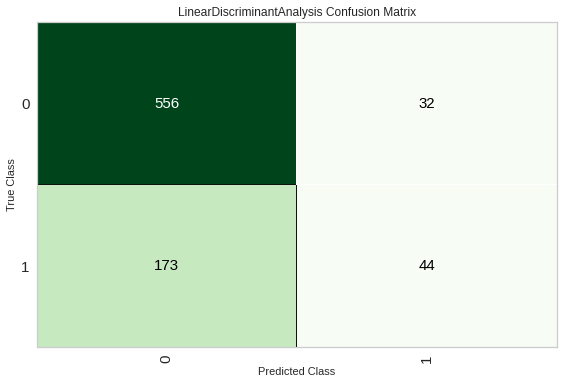

In [50]:
plot_model(models, 'confusion_matrix')

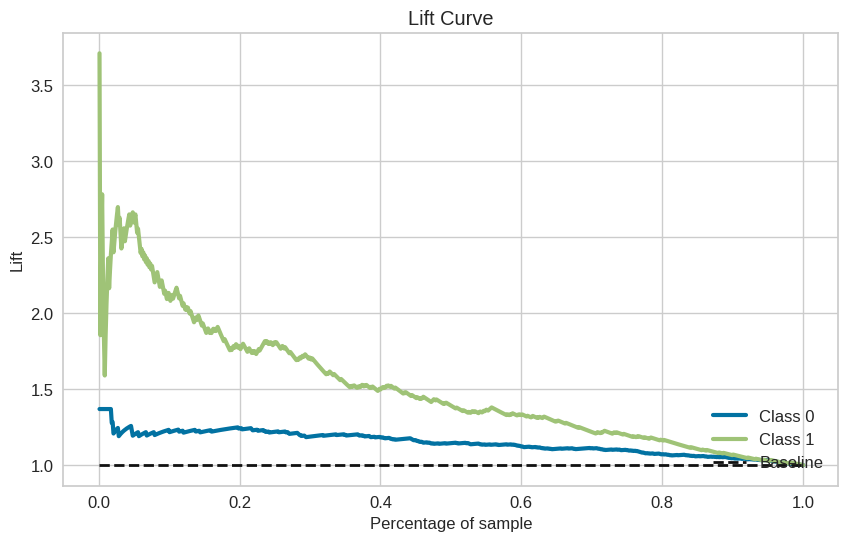

In [45]:
plot_model(models, 'lift')

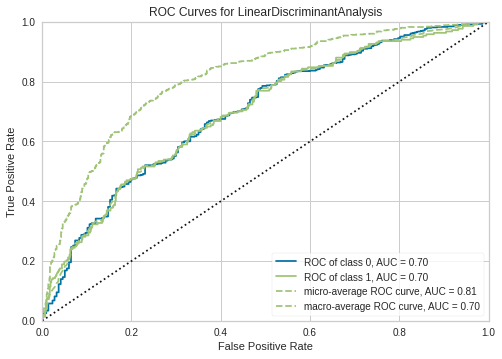

In [49]:
plot_model(models, 'auc')

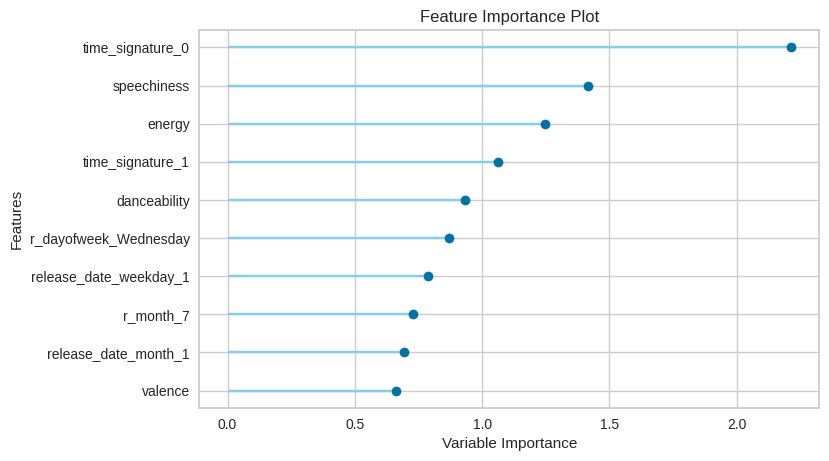

In [42]:
plot_model(models, 'feature')

Some of the most important predictors of whether or not a song will become a hit are intuitive. For example, energy and danceability have certainly increased over time, particularly for pop music.